# Импорты

In [1]:
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary

from src.data.dataset import TableDataset
from src.util.util import enumerateWithEstimate
from src.training import TableTrainingApp

# Примеры изображений в наборе данных

Text(0.5, 1.0, 'Чистый стол')

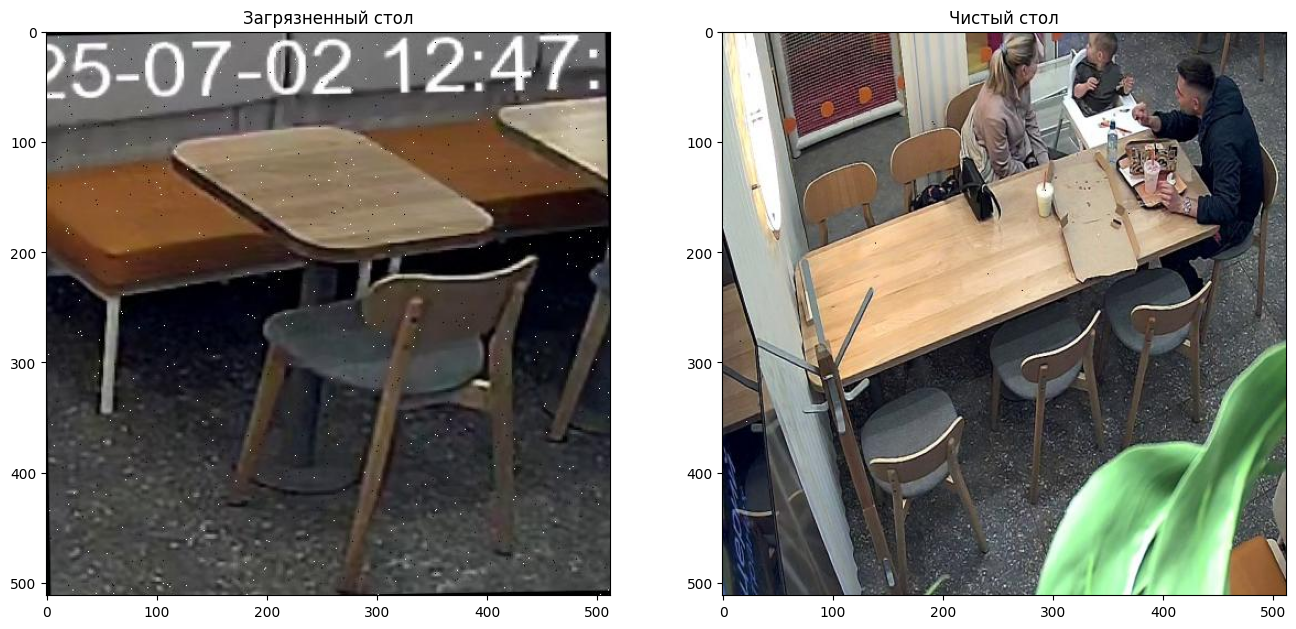

In [2]:
# Чтение изображения с загрязненным столом
img_dirty = cv2.imread('dataset/clean/table2_frame_00080_jpg.rf.b80b405fe21077c5957c334125d99bb7.jpg')
img_dirty = cv2.cvtColor(img_dirty, cv2.COLOR_BGR2RGB)

# Чтение изображения с загрязненным столом
img_clean = cv2.imread('dataset/dirty/table1_frame_00248_jpg.rf.1efe722426294e857d56c87c3651e0db.jpg')
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(img_dirty)
plt.title('Загрязненный стол')

plt.subplot(1, 2, 2)
plt.imshow(img_clean)
plt.title('Чистый стол')


# Пример работы с классом TableDataset

## Создание тренировочного набора данных

In [2]:
# Создание тренировочного набора данных с шагом 10 для валидации
data = TableDataset(val_stride=0, isValSet_bool=False)

print(f"Размер тренировочного набора данных: {len(data)}")

Размер тренировочного набора данных: 1203


Размер изображения: torch.Size([3, 280, 280])
Метка класса: tensor([0, 1])


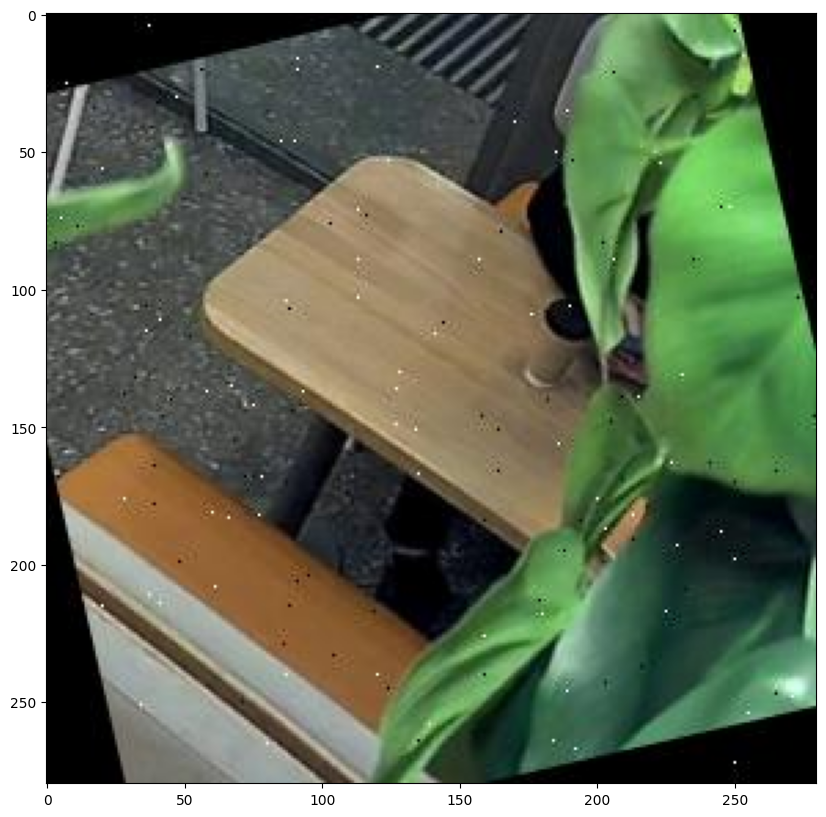

In [3]:
# Получение изображения и метки класса из набора
img_t, target = data[0]

print(f'Размер изображения: {img_t.shape}')
plt.figure(figsize=(10, 10))
plt.imshow(img_t.permute(1, 2, 0))

print(f"Метка класса: {target}")

## Работа генератора с выводом примерного времени ожидания прохода по пакетам

In [4]:
# Создаем DataLoader с размером пакета 64
dl = DataLoader(data, 64, num_workers=6,)

# Создание генератора по dl с выводом примерного времени ожидания
batch_iter = enumerateWithEstimate(dl, "Генератор прошел по", start_ndx=dl.num_workers)

for _ in batch_iter:
    pass

2025-11-09 22:10:23,707 WARNING  pid:36027     src.util.util:031:enumerateWithEstimate Генератор прошел по ----/19, starting
2025-11-09 22:10:24,521 INFO     pid:36027     src.util.util:047:enumerateWithEstimate Генератор прошел по   16/19, done at 2025-11-09 22:10:24, 0:00:00
2025-11-09 22:10:24,645 WARNING  pid:36027     src.util.util:060:enumerateWithEstimate Генератор прошел по ----/19, done at 2025-11-09 22:10:24


# Обучение модели на простом блоке

Простой блок состоит только из сверточных слоев и слоев субдискретизации (Max Pooling)

In [2]:
app = TableTrainingApp(['--num-workers=4', '--epoch=10', '--batch-size=16', '--conv-type=simple', '--img-size=280', '--depth=3', 'conv_simple_depth_3'])

2025-11-10 14:06:36,095 INFO     pid:16981     src.training:122:initModel Using CUDA; 1 devices.
2025-11-10 14:06:36,368 INFO     pid:16981     src.training:136:log_memory_usage GPU Memory After model loading:                 0.72GB allocated, 0.72GB reserved


In [3]:
summary(app.model, (3, 280, 280), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [16, 3, 280, 280]               6
            Conv2d-2         [16, 64, 280, 280]           1,792
            Conv2d-3         [16, 64, 280, 280]          36,928
       SimpleBlock-4         [16, 64, 140, 140]               0
            Conv2d-5         [16, 32, 140, 140]          18,464
            Conv2d-6         [16, 32, 140, 140]           9,248
       SimpleBlock-7           [16, 32, 70, 70]               0
            Conv2d-8           [16, 16, 70, 70]           4,624
            Conv2d-9           [16, 16, 70, 70]           2,320
      SimpleBlock-10           [16, 16, 35, 35]               0
      BatchNorm1d-11                [16, 19600]          39,200
           Linear-12                 [16, 9800]     192,089,800
           Linear-13                    [16, 2]          19,602
Total params: 192,221,984
Trainable par

In [4]:
app.main()

2025-11-10 14:06:37,663 INFO     pid:16981     src.training:191:main Starting TableTrainingApp, Namespace(num_workers=4, batch_size=16, epochs=10, balanced=False, img_size=280, conv_type='simple', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_simple_depth_3')
2025-11-10 14:06:37,668 INFO     pid:16981     src.training:196:main Epoch 1 of 10, 67/9 batches of size 16*1
2025-11-10 14:06:37,672 WARNING  pid:16981     src.util.util:031:enumerateWithEstimate E1 Training ----/67, starting
2025-11-10 14:06:39,916 INFO     pid:16981     src.util.util:047:enumerateWithEstimate E1 Training    8/67, done at 2025-11-10 14:06:53, 0:00:15
2025-11-10 14:06:41,857 INFO     pid:16981     src.util.util:047:enumerateWithEstimate E1 Training   16/67, done at 2025-11-10 14:06:53, 0:00:15
2025-11-10 14:06:45,748 INFO     pid:16981     src.util.util:047:enumerateWithEstimate E1 Training   32/67, done at 2025-11-10 14:06:54, 0:00:15
2025-11-10 14:06:53,626 INFO     pid:16981     src

# Обучение на блоке с пакетной нормализацией

In [2]:
app = TableTrainingApp(['--num-workers=4', '--epoch=10', '--batch-size=8', '--conv-type=batch', '--img-size=280', '--depth=3', 'conv_batch_depth_3'])

2025-11-10 15:57:54,563 INFO     pid:28002     src.training:127:initModel Using CUDA; 1 devices.
2025-11-10 15:57:54,857 INFO     pid:28002     src.training:141:log_memory_usage GPU Memory After model loading:                 0.72GB allocated, 0.72GB reserved


In [3]:
summary(app.model, (3, 280, 280), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [16, 3, 280, 280]               6
            Conv2d-2         [16, 64, 280, 280]           1,792
            Conv2d-3         [16, 64, 280, 280]          36,928
       BatchNorm2d-4         [16, 64, 280, 280]             128
        BatchBlock-5         [16, 64, 140, 140]               0
            Conv2d-6         [16, 32, 140, 140]          18,464
            Conv2d-7         [16, 32, 140, 140]           9,248
       BatchNorm2d-8         [16, 32, 140, 140]              64
        BatchBlock-9           [16, 32, 70, 70]               0
           Conv2d-10           [16, 16, 70, 70]           4,624
           Conv2d-11           [16, 16, 70, 70]           2,320
      BatchNorm2d-12           [16, 16, 70, 70]              32
       BatchBlock-13           [16, 16, 35, 35]               0
      BatchNorm1d-14                [16

In [4]:
app.main()

2025-11-10 15:57:55,074 INFO     pid:28002     src.training:215:main Starting TableTrainingApp, Namespace(num_workers=4, batch_size=8, epochs=10, balanced=False, img_size=280, conv_type='batch', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_batch_depth_3')
2025-11-10 15:57:55,079 INFO     pid:28002     src.training:222:main Epoch 1 of 10, 134/17 batches of size 8*1
2025-11-10 15:57:55,084 WARNING  pid:28002     src.util.util:031:enumerateWithEstimate E1 Training ----/134, starting
2025-11-10 15:57:57,719 INFO     pid:28002     src.util.util:047:enumerateWithEstimate E1 Training   16/134, done at 2025-11-10 15:58:14, 0:00:19
2025-11-10 15:58:04,815 INFO     pid:28002     src.util.util:047:enumerateWithEstimate E1 Training   64/134, done at 2025-11-10 15:58:15, 0:00:19
2025-11-10 15:58:15,079 WARNING  pid:28002     src.util.util:060:enumerateWithEstimate E1 Training ----/134, done at 2025-11-10 15:58:15
2025-11-10 15:58:15,157 INFO     pid:28002     src.traini

OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 99.06 MiB is free. Including non-PyTorch memory, this process has 5.00 GiB memory in use. Of the allocated memory 4.31 GiB is allocated by PyTorch, and 579.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Обучение на блоке с Dropout

In [2]:
app = TableTrainingApp(['--num-workers=6', '--epoch=10', '--batch-size=16', '--conv-type=dropout', '--img-size=280', '--depth=3', 'conv_dropout_depth_3'])

2025-11-10 15:04:42,804 INFO     pid:22405     src.training:122:initModel Using CUDA; 1 devices.
2025-11-10 15:04:43,075 INFO     pid:22405     src.training:136:log_memory_usage GPU Memory After model loading:                 0.72GB allocated, 0.72GB reserved


In [3]:
summary(app.model, (3, 280, 280), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [16, 3, 280, 280]               6
            Conv2d-2         [16, 64, 280, 280]           1,792
            Conv2d-3         [16, 64, 280, 280]          36,928
      DropoutBlock-4         [16, 64, 140, 140]               0
            Conv2d-5         [16, 32, 140, 140]          18,464
            Conv2d-6         [16, 32, 140, 140]           9,248
      DropoutBlock-7           [16, 32, 70, 70]               0
            Conv2d-8           [16, 16, 70, 70]           4,624
            Conv2d-9           [16, 16, 70, 70]           2,320
     DropoutBlock-10           [16, 16, 35, 35]               0
      BatchNorm1d-11                [16, 19600]          39,200
           Linear-12                 [16, 9800]     192,089,800
           Linear-13                    [16, 2]          19,602
Total params: 192,221,984
Trainable par

In [4]:
app.main()

2025-11-10 15:04:44,233 INFO     pid:22405     src.training:191:main Starting TableTrainingApp, Namespace(num_workers=6, batch_size=16, epochs=10, balanced=False, img_size=280, conv_type='dropout', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_dropout_depth_3')
2025-11-10 15:04:44,237 INFO     pid:22405     src.training:198:main Epoch 1 of 10, 67/9 batches of size 16*1
2025-11-10 15:04:44,241 WARNING  pid:22405     src.util.util:031:enumerateWithEstimate E1 Training ----/67, starting
2025-11-10 15:04:48,586 INFO     pid:22405     src.util.util:047:enumerateWithEstimate E1 Training   16/67, done at 2025-11-10 15:05:01, 0:00:15
2025-11-10 15:04:52,606 INFO     pid:22405     src.util.util:047:enumerateWithEstimate E1 Training   32/67, done at 2025-11-10 15:05:01, 0:00:15
2025-11-10 15:05:00,634 INFO     pid:22405     src.util.util:047:enumerateWithEstimate E1 Training   64/67, done at 2025-11-10 15:05:01, 0:00:15
2025-11-10 15:05:01,272 WARNING  pid:22405     s

OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 336.31 MiB is free. Including non-PyTorch memory, this process has 4.74 GiB memory in use. Of the allocated memory 4.31 GiB is allocated by PyTorch, and 320.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)